# Credit Card Routing Analysis

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import warnings
import sys
warnings.filterwarnings('ignore')

In [98]:
# PSP Fee definitions
psp_fees = {
    'Moneycard': {'success_fee': 5.00, 'fail_fee': 2.00},
    'Goldcard': {'success_fee': 10.00, 'fail_fee': 5.00},
    'UK_Card': {'success_fee': 3.00, 'fail_fee': 1.00},
    'Simplecard': {'success_fee': 1.00, 'fail_fee': 0.50},
}

In [99]:
def load_and_clean_dataset(file):   # 1. Data Preperation and cleanup of the CSV file provided
    try:
        fileData = pd.read_excel(file)
        fileData['tmsp'] = pd.to_datetime(fileData['tmsp'])
        fileData = fileData.dropna()
        print("\nFile read and cleaned successfully.")
        return fileData
    except FileNotFoundError:
        print(f"\nFile not found: {file}")
        sys.exit(1)
    except Exception as e:
        print(f"\nError loading dataset: {str(e)}")
        sys.exit(1)

In [100]:
# Feature engineering
def engineer_features_data_prep(fileData):
    try:
        fileData['hour'] = fileData['tmsp'].dt.hour
        fileData['day'] = fileData['tmsp'].dt.day
        fileData['weekday'] = fileData['tmsp'].dt.weekday
        fileData['month'] = fileData['tmsp'].dt.month
        fileData = fileData.sort_values('tmsp')
        fileData['prev_tmsp'] = fileData.groupby(['country', 'amount'])['tmsp'].shift(1)
        fileData['seconds_diff'] = (fileData['tmsp'] - fileData['prev_tmsp']).dt.total_seconds()
        fileData['is_retry'] = fileData['seconds_diff'].lt(60).fillna(False).astype(int)
        print("\nFeature engineering completed.")
        return fileData
    except Exception as e:
        print(f"\nFeature engineering error: {str(e)}")
        sys.exit(1)

In [101]:
def run_Exploratory_Data_Analysis(data):    # 3. Basic Exploratory Data Analysis
    try:
        print("\nSuccess rate per PSP:")
        print(data.groupby("PSP")['success'].mean())
        print("\nSuccess rate by 3D Secure flag:")
        print(data.groupby("3D_secured")['success'].mean())
        pivot = data.pivot_table(index='hour', columns='PSP', values='success', aggfunc='mean')
        sns.heatmap(pivot, annot=True, cmap='YlGnBu')
        plt.title("Success Rate by Hour and PSP:")
        plt.show()
        sns.barplot(x='PSP', y='success', data=data, ci=None)
        plt.title("Success Rate by PSP")
        plt.show()
        sns.barplot(data = data.groupby('hour')['success'].mean().reset_index(), x='hour', y='success')
        plt.title("Success Rate by hour")
        plt.show()
        sns.barplot(data = data.groupby('country')['success'].mean().reset_index(), x='country', y='success')
        plt.title("Success Rate by country")
        plt.show()
    except Exception as e:
        print(f"\nError during EDA: {str(e)}")
        sys.exit(1)


In [102]:
def prepare_model_data(df): # 4. Prepare Data for Model to train. 80/20 split applied here
    try:
        df_model = pd.get_dummies(df, columns=['PSP', 'country', 'card'], drop_first=True)
        features = ['amount', '3D_secured', 'hour', 'weekday', 'is_retry'] + \
                   [col for col in df_model.columns if col.startswith(('PSP_', 'country_', 'card_'))]
        X = df_model[features]
        y = df_model['success']
        print("\nModel prepared!")
        return train_test_split(X, y, test_size=0.2, random_state=42), features
    except Exception as e:
        print(f"\nError during model preparation: {str(e)}")
        sys.exit(1)

In [103]:
def train_predictive_model(X_train, y_train, X_test, y_test):   # 5. The prepared model trained to extract classifier report
    try:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("\nModel Performance:")
        print(classification_report(y_test, y_pred))
        return model
    except Exception as e:
        print(f"\nError during model training: {str(e)}")
        sys.exit(1)

In [104]:
def train_routing_models(df, features): # 6. PSP Routing Simulation
    try:
        psp_models = {}
        psps = df['PSP'].unique()
        df_encoded = pd.get_dummies(df, columns=['PSP', 'country', 'card'], drop_first=True)
        for psp in psps:
            df_encoded['target'] = (df['PSP'] == psp) & (df['success'] == 1)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(df_encoded[features], df_encoded['target'])
            psp_models[psp] = model
        return psp_models
    except Exception as e:
        print(f"\nError during train routing model: {str(e)}")
        sys.exit(1)

In [105]:
def simulate_routing_with_cost(psp_models, sample_tx, psp_fees):
    try:
        scores = {}
        for psp, model in psp_models.items():
            prob_success = model.predict_proba(sample_tx)[0][1]
            fees = psp_fees[psp]
            expected_cost = prob_success * fees['success_fee'] + (1 - prob_success) * fees['fail_fee']
            scores[psp] = {'prob': prob_success, 'expected_cost': expected_cost}
            print(f"{psp}: Expected cost: €{expected_cost:.2f}")
        # Find PSP with lowest expected cost
        best_psp = min(scores.items(), key=lambda x: x[1]['expected_cost'])
        print("\nPSP Scores (Success Probability and Expected Cost):")
        for psp, data in scores.items():
            print(f"{psp}: P(success)={data['prob']:.2f}, Expected Cost={data['expected_cost']:.4f} €")
        print(f"\nOptimal PSP (lowest expected cost): {best_psp[0]} with cost {best_psp[1]['expected_cost']:.4f} €")
        return best_psp[0]
    except Exception as e:
        print(f"\nError during cost related simulation: {str(e)}")
        sys.exit(1)

In [106]:
def runConfusionMatrix(X_test, model, y_test):
    try:
        y_pred = model.predict(X_test)
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
        plt.title("Confusion Matrix")
        plt.show()
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"\nError during confusion matrix display: {str(e)}")
        sys.exit(1)


File read and cleaned successfully.

Feature engineering completed.

Success rate per PSP:
PSP
Goldcard      0.406172
Moneycard     0.218754
Simplecard    0.158123
UK_Card       0.194338
Name: success, dtype: float64

Success rate by 3D Secure flag:
3D_secured
0    0.189562
1    0.245525
Name: success, dtype: float64


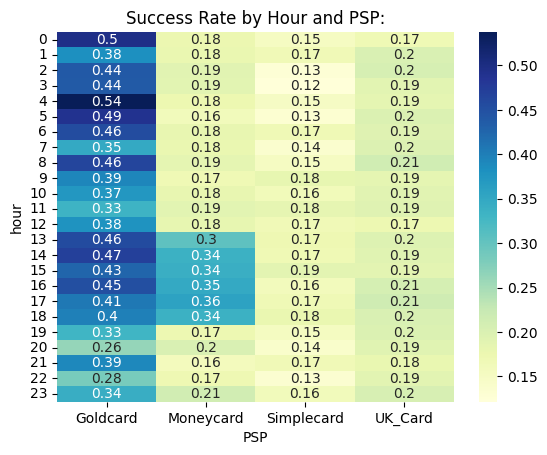

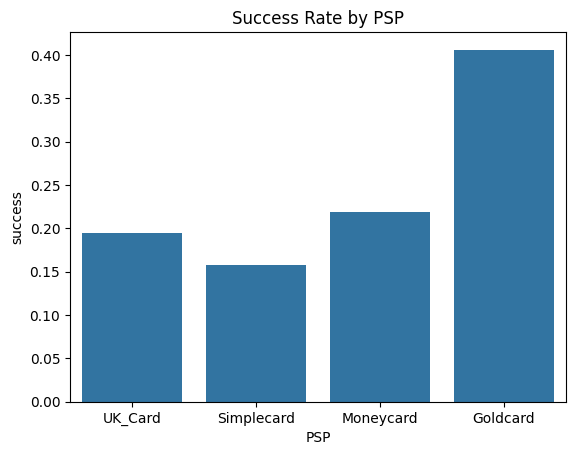

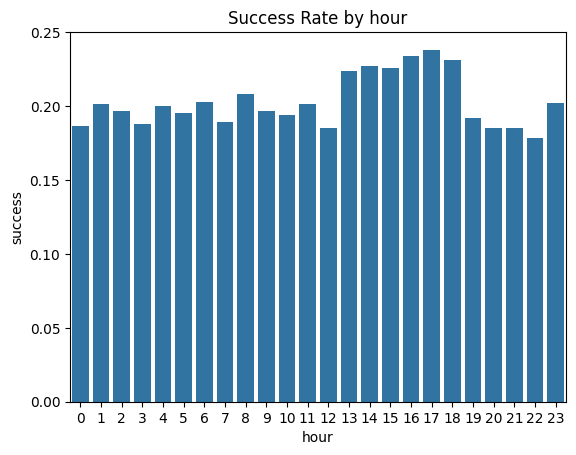

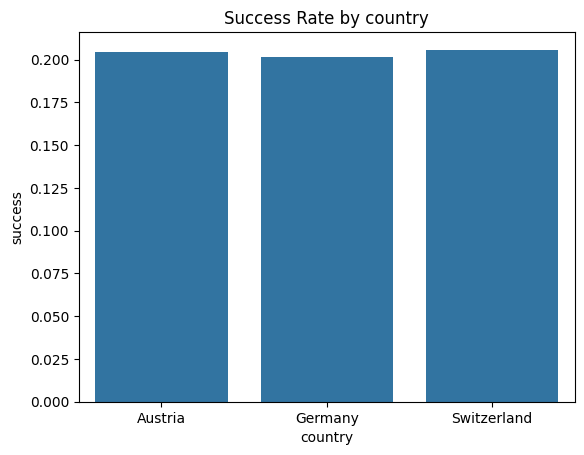


Model prepared!

Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      8163
           1       0.29      0.13      0.18      1919

    accuracy                           0.77     10082
   macro avg       0.56      0.53      0.53     10082
weighted avg       0.72      0.77      0.74     10082



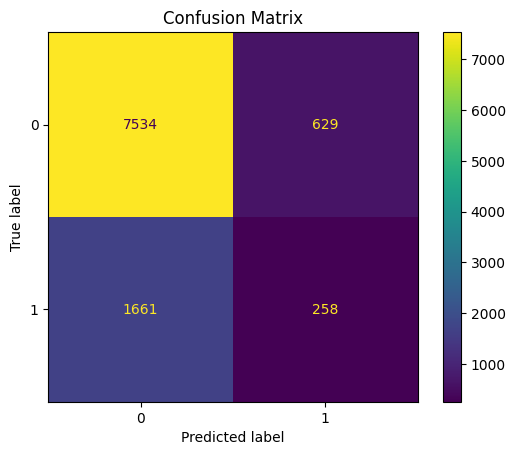

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      8163
           1       0.29      0.13      0.18      1919

    accuracy                           0.77     10082
   macro avg       0.56      0.53      0.53     10082
weighted avg       0.72      0.77      0.74     10082

UK_Card: Expected cost: €1.10
Simplecard: Expected cost: €0.50
Moneycard: Expected cost: €2.00
Goldcard: Expected cost: €5.00

PSP Scores (Success Probability and Expected Cost):
UK_Card: P(success)=0.05, Expected Cost=1.1000 €
Simplecard: P(success)=0.00, Expected Cost=0.5000 €
Moneycard: P(success)=0.00, Expected Cost=2.0000 €
Goldcard: P(success)=0.00, Expected Cost=5.0000 €

Optimal PSP (lowest expected cost): Simplecard with cost 0.5000 €


In [107]:
# Main Execution
if __name__ == "__main__":
    filepath = "PSP_Jan_Feb_2019.xlsx"  #Reading the CSV file
    try:
        # Load + Process + data cleanup
        df = load_and_clean_dataset(filepath)
        df = engineer_features_data_prep(df)
        # Exploratory Data Analysis
        run_Exploratory_Data_Analysis(df)
        # Modeling
        (X_train, X_test, y_train, y_test), features = prepare_model_data(df)
        model = train_predictive_model(X_train, y_train, X_test, y_test)
        runConfusionMatrix(X_test, model, y_test)
        # Routing Simulation
        psp_models = train_routing_models(df, features)
        # Pick a sample and simulate routing
        if not X_test.empty:
            sample_tx = X_test.iloc[[0]]  # First row of test set
            simulate_routing_with_cost(psp_models, sample_tx, psp_fees)
        else:
            print(" No test data available to simulation routing.")
    except Exception as e:
        print(f"\n Unexpected error in main: {str(e)}")
        sys.exit(1)